In [49]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime, joblib
import statsmodels.api as sm
from itertools import product

In [64]:
# Reading the DataFrame separated by tab
seeing = pd.read_csv('WHTR2D2_seeing', header=0, parse_dates=[0], index_col=0, sep='\t')

# Displaying the first 5 lines
seeing.head()

,Arcsec
DateTimeUT,
2024-02-17 20:23:17,2.4608
2024-02-17 20:34:02,2.1090
2024-02-17 21:15:29,1.6439
2024-02-17 21:39:42,1.4338
2024-02-17 21:40:49,1.3507


(array([19754., 19756., 19758., 19760., 19762., 19764., 19766., 19768.,
        19770.]),
 [Text(19754.0, 0, '2024-02-01'),
  Text(19756.0, 0, '2024-02-03'),
  Text(19758.0, 0, '2024-02-05'),
  Text(19760.0, 0, '2024-02-07'),
  Text(19762.0, 0, '2024-02-09'),
  Text(19764.0, 0, '2024-02-11'),
  Text(19766.0, 0, '2024-02-13'),
  Text(19768.0, 0, '2024-02-15'),
  Text(19770.0, 0, '2024-02-17')])

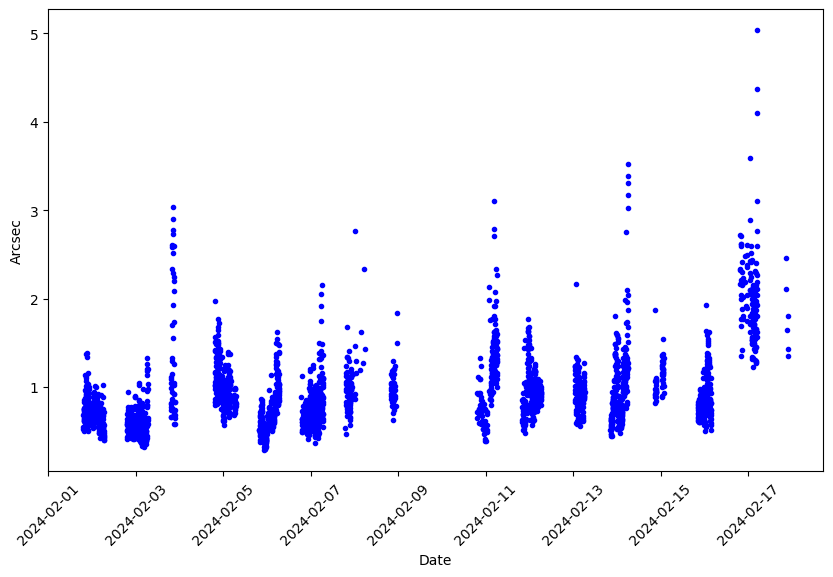

In [90]:
# Plotear los datos observados
plt.figure(figsize=(10, 6))
plt.plot(seeing.index, seeing['Arcsec'], 'b.', label='Observations')
plt.xlabel('Date'); plt.ylabel('Arcsec')
plt.xticks(rotation=45)

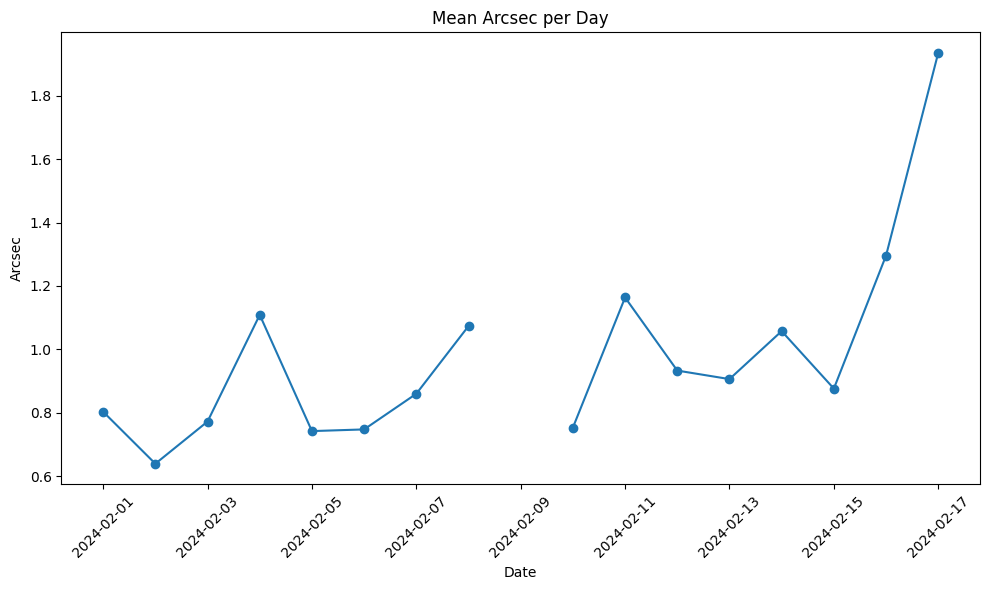

In [91]:
# Convertir la columna DateTimeUT en el índice de tipo DatetimeIndex
seeing.index = pd.to_datetime(seeing.index)

# Resample para agrupar los datos por semana y calcular la media
seeing_weekly = seeing.resample('D').mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(seeing_weekly.index, seeing_weekly['Arcsec'], marker='o')
plt.xlabel('Date')
plt.ylabel('Arcsec')
plt.title('Mean Arcsec per Day')
plt.xticks(rotation=45)  # Rotar las fechas para que sean legibles
plt.tight_layout()
plt.show()

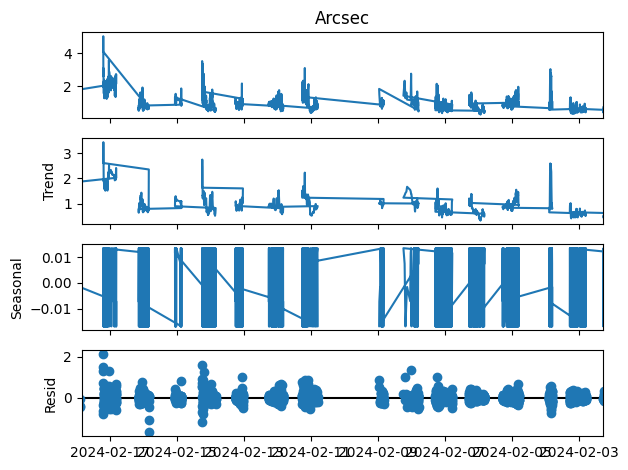

In [54]:
# Convertir la columna DateTimeUT en el índice de tipo DatetimeIndex
seeing.index = pd.to_datetime(seeing.index)

# Realizar la descomposición estacional
season = 7 # Seasonality
res = seasonal_decompose(seeing['Arcsec'], period=season)  # Cambia el período según la frecuencia de datos
res.plot()
plt.show()

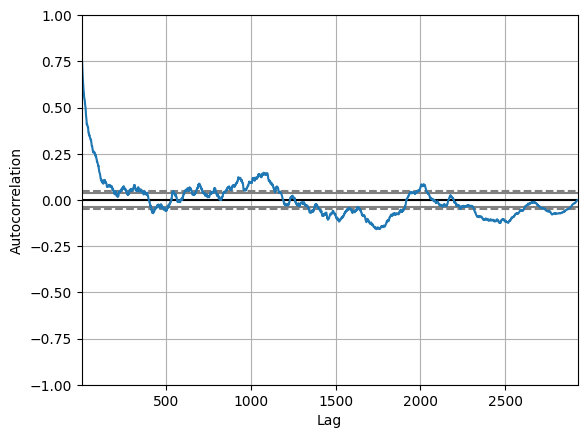

In [65]:
seeinglog = np.log(seeing) # Pasamos a escala logaritmica

# Autocorrelación de las series
pd.plotting.autocorrelation_plot(seeinglog);

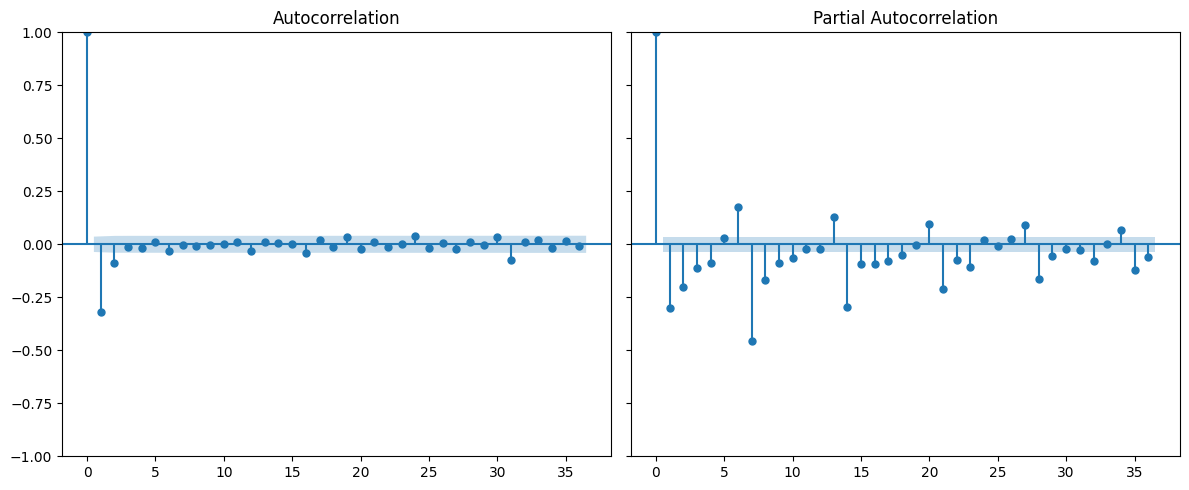

In [68]:
# Proceso de dobles diferencias
seeinglog_1 = seeinglog.diff().dropna() # 1st order differencing
seeinglog_2 = seeinglog_1.diff(periods = season).dropna() # 7 order difference

# Plot on 36 lags the simple and partial autocorrelograms of the doubly differenced time series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

plot_acf(seeinglog_1, lags = 36, ax=ax1)
plot_pacf(seeinglog_2, lags = 36, ax=ax2)
plt.tight_layout()

In [69]:
import warnings
warnings.filterwarnings('ignore')

def find_best_sarima(seeinglog, p_values, d_values, q_values, P_values, D_values, Q_values, S=season, njobs=10):
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None

    def evaluate_params(params):
        p, d, q, P, D, Q = params
        try:
            model = sm.tsa.SARIMAX(seeinglog,
                                   order=(p, d, q),
                                   seasonal_order=(P, D, Q, S),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            results = model.fit(disp=False)
            return results.aic, (p, d, q), (P, D, Q, S)
        except:
            return float('inf'), None, None

    # Use joblib to parallelize the parameter search
    results = joblib.Parallel(n_jobs=njobs)(
        joblib.delayed(evaluate_params)(params)
        for params in product(p_values, d_values, q_values, P_values, D_values, Q_values)
    )

    # Find the best result among all parallel processes
    for aic, order, seasonal_order in results:
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_seasonal_order = seasonal_order

    return best_aic, best_order, best_seasonal_order

# Defining a range of the different parameters for the SARIMA model
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
S = season # Seasonality

best_aic, best_order, best_seasonal_order = find_best_sarima(seeinglog, p_values, d_values, q_values, P_values, D_values, Q_values)

# Create the best SARIMA model with the new parameters
best_model = sm.tsa.SARIMAX(seeinglog,
                            order=best_order,
                            seasonal_order=best_seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
# Fit the best model to the data
results = best_model.fit(disp=True)

print('\n')
print('=================================')
print('Best AIC:', best_aic)
print('Best order:', best_order)
print('Best seasonal order:', best_seasonal_order)
print('=================================')
print('\n')

print(results.summary())

/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09839D-01    |proj g|=  1.60329D-01

At iterate    1    f= -2.10335D-01    |proj g|=  5.74935D-02

At iterate    2    f= -2.10418D-01    |proj g|=  5.68409D-02

At iterate    3    f= -2.10842D-01    |proj g|=  9.76435D-02

At iterate    4    f= -2.11326D-01    |proj g|=  1.22899D-01

At iterate    5    f= -2.11509D-01    |proj g|=  9.97391D-02

At iterate    6    f= -2.11618D-01    |proj g|=  1.57702D-02

At iterate    7    f= -2.11620D-01    |proj g|=  4.06314D-03

At iterate    8    f= -2.11623D-01    |proj g|=  8.88870D-03

At iterate    9    f= -2.11637D-01    |proj g|=  2.42858D-02

At iterate   10    f= -2.11667D-01    |proj g|=  4.34887D-02

At iterate   11    f= -2.11722D-01    |proj g|=  5.83385D-02

At iterate   12    f= -2.11785D-01    |proj g|=  4.59016D-02

At iterate   13    f= -2.1

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     61      2     0     0   2.373D-05  -2.118D-01
  F = -0.21181438529547589     

ABNORMAL_TERMINATION_IN_LNSRCH                              


Best AIC: -1232.3850402903067
Best order: (2, 0, 1)
Best seasonal order: (0, 0, 0, 7)


                               SARIMAX Results                                
Dep. Variable:                 Arcsec   No. Observations:                 2928
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 620.193
Date:                Sun, 18 Feb 2024   AIC                          -1232.385
Time:            


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


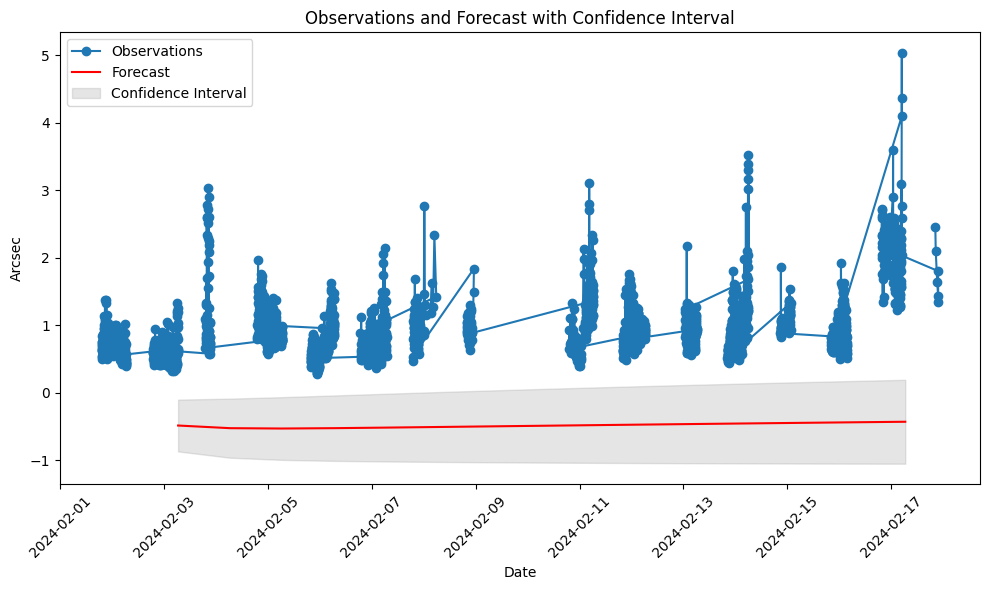

In [93]:
# Obtener la predicción para los próximos 15 días
forecast = results.get_forecast(steps=15)

# Plotear los datos observados
plt.figure(figsize=(10, 6))
plt.plot(seeing.index, seeing['Arcsec'], label='Observations', marker='o')

# Plotear la predicción
forecast_index = pd.date_range(start=seeing.index[-1], periods=16)[1:]
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')

# Obtener los límites inferiores y superiores del intervalo de confianza
lower_bound = forecast.conf_int()['lower Arcsec']
upper_bound = forecast.conf_int()['upper Arcsec']

# Plotear la zona sombreada del intervalo de confianza
plt.fill_between(forecast_index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Arcsec')
plt.title('Observations and Forecast with Confidence Interval')
plt.xticks(rotation=45)  # Rotar las fechas para que sean legibles
plt.legend()
plt.tight_layout()
plt.show()